<a href="https://colab.research.google.com/github/Yangl1492/Fraud-Detection/blob/main/Yang_model_training_and_parameter_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import os
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
!pip install category_encoders
from category_encoders.cat_boost import CatBoostEncoder
from sklearn import svm
from sklearn.cluster import DBSCAN
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
!pip install catboost
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import RandomizedSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_auc_score
import torch
import random
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report
import torch.nn as nn
import torch.optim as optim
from tensorflow import keras
from tensorflow.keras import layers
import torch
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 18.8 MB/s eta 0:00:00


In [ ]:
drive.mount('/content/gdrive')
os.chdir("/content/gdrive/MyDrive/Colab Notebooks")
import altair as alt
from IPython.display import display

Mounted at /content/gdrive


# Data Load and preprocessing

In [ ]:
df = pd.read_csv('train_all_inner.csv', index_col = 0)
print(df.shape)
df.head()

(144233, 434)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0,86506,50.000,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,0,86535,15.000,H,2803,100.0,150.0,visa,226.0,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,0,86549,75.887,C,16496,352.0,117.0,mastercard,134.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,0,86555,16.495,C,4461,375.0,185.0,mastercard,224.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0,86620,30.000,H,1790,555.0,150.0,visa,226.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [ ]:
# NULL Value Table
def create_summary_table(df):
  summary = pd.DataFrame(index = df.columns)
  summary['Data Type'] = df.dtypes.values
  summary['# Nonnull records'] = df.count().values
  summary['# Non-zero records'] = df.astype(bool).sum(axis=0)
  summary['% null records'] = round(df.isna().sum()/df.shape[0]*100,2)
  summary['% non-zero records'] = round(df.astype(bool).sum(axis=0) / df.shape[0]*100,2)
  summary['Unique values'] = df.nunique().values
  summary.to_csv('summary_table.csv')
  return summary

In [ ]:
summary = create_summary_table(df)
summary

,Data Type,# Nonnull records,# Non-zero records,% null records,% non-zero records,Unique values
TransactionID,int64,144233,144233,0.00,100.00,144233
isFraud,int64,144233,11318,0.00,7.85,2
TransactionDT,int64,144233,144233,0.00,100.00,142734
TransactionAmt,float64,144233,144233,0.00,100.00,7830
ProductCD,object,144233,144233,0.00,100.00,4
...,...,...,...,...,...,...
id_36,object,140985,144233,2.25,100.00,2
id_37,object,140985,144233,2.25,100.00,2
id_38,object,140985,144233,2.25,100.00,2
DeviceType,object,140810,144233,2.37,100.00,2


In [ ]:
summary.to_csv('summary_table.csv')

### Split categorical and numerical features

In [ ]:
full_data_col = df.loc[:, df.isnull().sum() == 0].columns.values
feature_col = df.columns[df.dtypes == 'object']
numerical_col = df.columns[df.dtypes != 'object']
feature_col_NAN = [col for col in feature_col if col not in full_data_col]
numerical_col_NAN = [col for col in numerical_col if col not in full_data_col]
num_full_col = [col for col in numerical_col if col in full_data_col]

### Calculate corr and mic

In [ ]:
# we would like to calculate the correlation of all numerical columns with the target column
corr_map = {}
target_col = df['isFraud']
for col in numerical_col_NAN:
    new = df.filter(['isFraud',col], axis=1)
    new = new.dropna(how='any')
    corr= new['isFraud'].corr(df[col])
    corr_map[col] = corr
    # print('feature: ', col)
    # print('Pearsons correlation: %.3f' % corr)

In [ ]:
top_10_abs_values = sorted(corr_map.items(), key=lambda item: abs(item[1]), reverse=True)[:10]
print("Top 10 absolute correlation values and their keys:")
for key, value in top_10_abs_values:
  print(f"Key: {key}, Value: {value}")
# the results show that there is no numerical values have high correlationship with target column('isFraud')

Top 10 absolute correlation values and their keys:
Key: V257, Value: 0.3832856148820498
Key: card3, Value: 0.14845948588273858
Key: dist1, Value: nan
Key: D5, Value: -0.14725979020983607
Key: D8, Value: -0.14263641015850023
Key: D7, Value: -0.12907747541796874
Key: D2, Value: -0.10221455720426491
Key: D10, Value: -0.07273693466694602
Key: D6, Value: -0.06172143782166901
Key: D4, Value: -0.04759094462339414


In [ ]:
'''# 在之后计算的时候，需要把target换成所有non unique value 的特征
# mine.compute_score(x, y)
mine = MINE(alpha=0.6)
mic_map = {}
target_col = df['isFraud']
for col in numerical_col_NAN:
    mine.compute_score(target_col, df[col])
    mic_map[col] = mine.mic()'''

"# 在之后计算的时候，需要把target换成所有non unique value 的特征\n# mine.compute_score(x, y)\nmine = MINE(alpha=0.6)\nmic_map = {}\ntarget_col = df['isFraud']\nfor col in numerical_col_NAN:\n    mine.compute_score(target_col, df[col])\n    mic_map[col] = mine.mic()"

### Drop data by NAN% and dominate %

In [ ]:
def threshold(t_null, t_dominant, df):
    many_null_col = list(set(
        [col for col in df.columns if df[col].isnull().mean() > t_null]))

    dominant_value_col =list(set(
        [col for col in df.columns
            if df[col].value_counts(dropna=False, normalize=True).values[0] > t_dominant]))
    cols_to_drop = list(set(many_null_col+
        dominant_value_col))
    return cols_to_drop

In [ ]:
cols_to_drop=threshold(0.2, 0.8, df)
cols_to_drop.remove('isFraud')
df_drop = df.drop(columns=cols_to_drop)

print(df_drop.shape)
df_drop.head()

(144233, 83)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_19,id_20,id_28,id_29,id_31,id_35,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0,86506,50.000,H,4497,514.0,150.0,mastercard,102.0,...,542.0,144.0,New,NotFound,samsung browser 6.2,T,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,0,86535,15.000,H,2803,100.0,150.0,visa,226.0,...,621.0,500.0,New,NotFound,mobile safari 11.0,T,F,T,mobile,iOS Device
2,2987010,0,86549,75.887,C,16496,352.0,117.0,mastercard,134.0,...,410.0,142.0,Found,Found,chrome 62.0,F,T,T,desktop,Windows
3,2987011,0,86555,16.495,C,4461,375.0,185.0,mastercard,224.0,...,176.0,507.0,New,NotFound,chrome 62.0,F,T,T,desktop,NaN
4,2987016,0,86620,30.000,H,1790,555.0,150.0,visa,226.0,...,529.0,575.0,Found,Found,chrome 62.0,T,T,T,desktop,MacOS


In [ ]:
full_data_col = df_drop.loc[:, df_drop.isnull().sum() == 0].columns.values
categorical_col = df_drop.columns[df_drop.dtypes == 'object']
numerical_col = df_drop.columns[df_drop.dtypes != 'object']
categorical_col_NAN = [col for col in categorical_col if col not in full_data_col]
numerical_col_NAN = [col for col in numerical_col if col not in full_data_col]
num_full_col = [col for col in numerical_col if col in full_data_col]
categorical_full_col = [col for col in categorical_col if col in full_data_col]

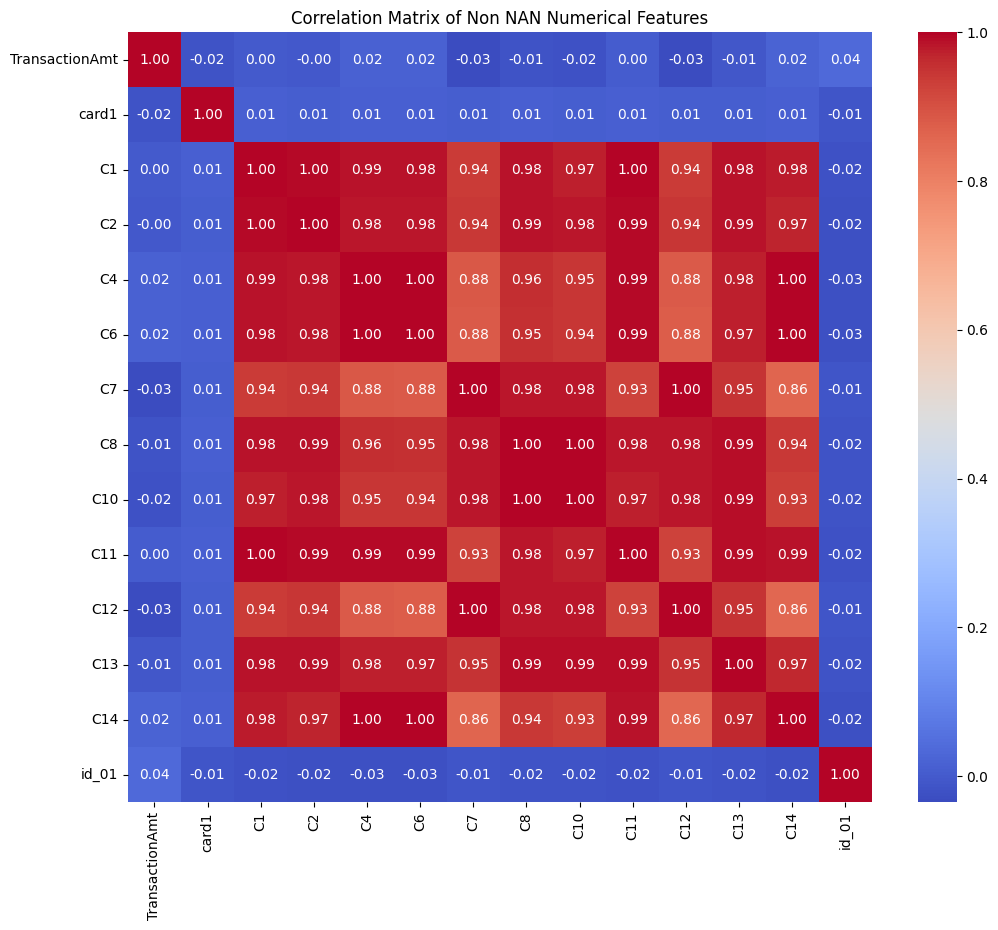

In [ ]:
# the we would like to see the correlationship among non nan numerical features
df_corr = df[num_full_col[3:]].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(df_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Non NAN Numerical Features')
plt.show()

In [ ]:
df_drop_summary = create_summary_table(df_drop)
df_drop_summary.loc[numerical_col_NAN,'Unique values']

,Unique values
card2,482
card3,103
card5,106
D1,641
V167,873
V168,965
V170,49
V171,62
V202,10970
V203,14951


### correlation among numerical_col_nan and numerical_full_col

In [ ]:
non_nan_num_col = ['TransactionAmt','card1','C1','id_01']
corr_check ={}
for nan_col in numerical_col_NAN:
    corr_check[nan_col]={}
    for full_col in non_nan_num_col:
        correlation = df_drop[nan_col].corr(df_drop[full_col])
        corr_check[nan_col][full_col] = correlation
avg_corr, max_feature, max_corr = [],[],[]
for i in corr_check.values():
    each_corr_value = list(i.values())
    each_corr_feature = list(i.keys())
    avg_corr.append(sum(each_corr_value)/len(each_corr_value))
    abs_corr = list(map(lambda x: abs(x), each_corr_value))
    max_abs_index = abs_corr.index(max(abs_corr))
    max_feature.append(each_corr_feature[max_abs_index])
    max_corr.append(each_corr_value[max_abs_index])

In [ ]:
df_corr_check = pd.DataFrame(list(zip(*[numerical_col_NAN, avg_corr, max_feature, max_corr])),
                             columns=['Nan_Feature', 'Avg_Corr', 'Max_NotNull_Feature', 'Max_Corr_Abs']).sort_values(by='Max_Corr_Abs')
df_corr_check = df_corr_check.reindex(df_corr_check['Max_Corr_Abs'].abs().sort_values(ascending=False).index)
df_corr_check.head()

,Nan_Feature,Avg_Corr,Max_NotNull_Feature,Max_Corr_Abs
48,id_17,-0.109185,TransactionAmt,-0.334971
1,card3,-0.071577,TransactionAmt,-0.256826
46,id_06,0.055615,id_01,0.201637
2,card5,-0.042325,card1,-0.199373
32,V263,0.045591,TransactionAmt,0.156411


#### Deal with Categorical Features

1. KNN：card6, id_16,id_28,id_29,id_35,id_37,id_38,card4, Device Type
3. Simply Fill, id_15->Unknow
4. Need preprocess: P_emaildomain, R_emaildomain,id_31 and Device info

In [ ]:
categorical_col_NAN

['card4',
 'card6',
 'P_emaildomain',
 'R_emaildomain',
 'id_15',
 'id_16',
 'id_28',
 'id_29',
 'id_31',
 'id_35',
 'id_37',
 'id_38',
 'DeviceType',
 'DeviceInfo']

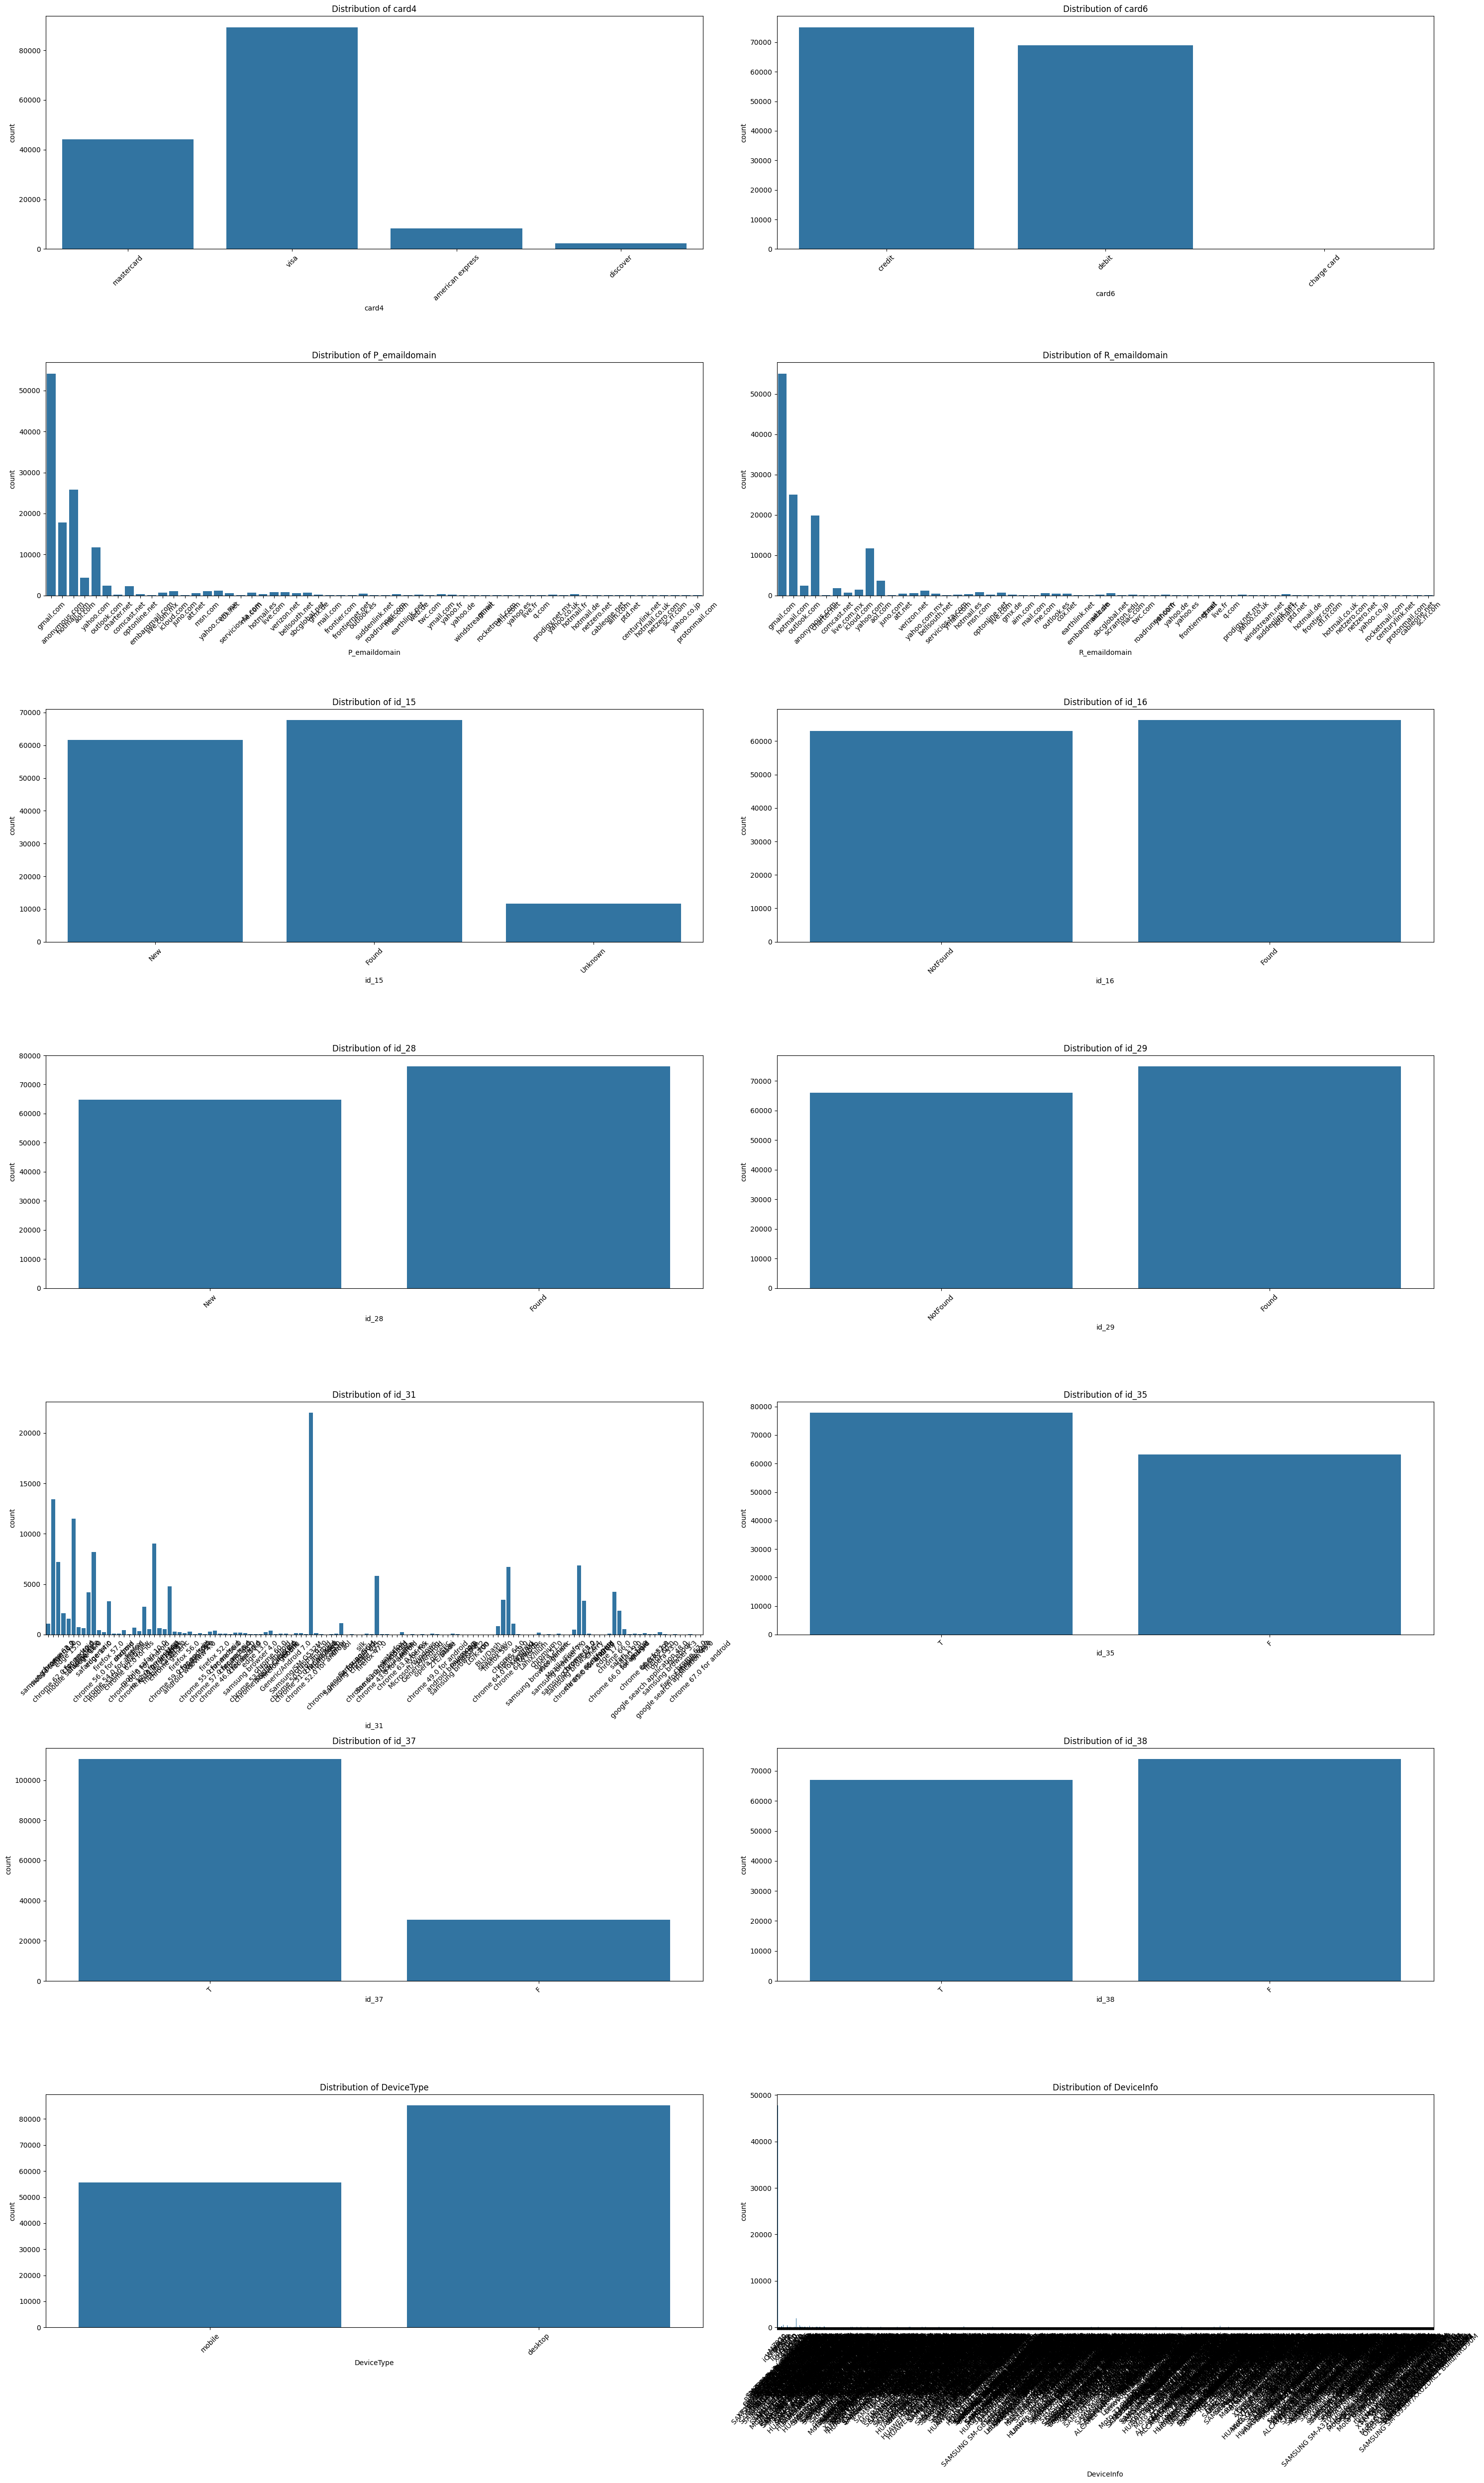

In [ ]:
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(30, 50))
axes = axes.flatten()

# Plot the distribution of each categorical feature
for i, col in enumerate(categorical_col_NAN):
    sns.countplot(data=df_drop, x=col, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
PCA_list = ['C1', 'C2', 'C4', 'C6', 'C7', 'C8', 'C10', 'C11', 'C12', 'C13', 'C14']
C_X = df_drop.loc[:,PCA_list]
scaler = StandardScaler()
pca = PCA(n_components=1)
pca.fit(scaler.fit_transform(C_X))
C_PCA = pca.transform(C_X)

In [ ]:
df_drop = df_drop.copy().drop(columns = PCA_list)
df_drop['C_PCA'] = C_PCA

In [ ]:
full_data_col = df_drop.loc[:, df_drop.isnull().sum() == 0].columns.values
categorical_col = df_drop.columns[df_drop.dtypes == 'object']
numerical_col = df_drop.columns[df_drop.dtypes != 'object']

categorical_col_NAN = [col for col in categorical_col if col not in full_data_col]
numerical_col_NAN = [col for col in numerical_col if col not in full_data_col]
numerical_col_FULL = [col for col in numerical_col if col in full_data_col]

##### KNN filling

In [ ]:
def fill_na_knn_classifier(df, feature_with_nan, non_nan_features):
    missing_mask = df[feature_with_nan].isna()
    X_train = df.loc[~missing_mask, non_nan_features]
    y_train = df.loc[~missing_mask, feature_with_nan]
    X_test = df.loc[missing_mask, non_nan_features]
    '''print('X_train shape', X_train.shape)
    print('y_train shape', y_train.shape)
    print('X_test shape', X_test.shape)'''
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    # print('finish model train')
    # print('shape of missing', df.loc[missing_mask, feature_with_nan])
    # print('shape of prediction', df.loc[missing_mask, feature_with_nan])
    df.loc[missing_mask, feature_with_nan] = y_pred
    return df


In [ ]:
numerical_col_FULL

['TransactionID',
 'isFraud',
 'TransactionDT',
 'TransactionAmt',
 'card1',
 'id_01',
 'C_PCA']

In [ ]:
knn_filling_freatures = ['card6', 'id_16', 'id_28', 'id_29', 'id_35', 'id_37', 'id_38', 'card4','DeviceType']
new_df = df_drop.copy()
for col in knn_filling_freatures:
    # print('col shape', )
    new_df = fill_na_knn_classifier(new_df, col,numerical_col_FULL)

In [ ]:
new_df_summary = create_summary_table(new_df)
new_df_summary.loc[knn_filling_freatures]

,Data Type,# Nonnull records,# Non-zero records,% null records,% non-zero records,Unique values
card6,object,144233,144233,0.0,100.0,3
id_16,object,144233,144233,0.0,100.0,2
id_28,object,144233,144233,0.0,100.0,2
id_29,object,144233,144233,0.0,100.0,2
id_35,object,144233,144233,0.0,100.0,2
id_37,object,144233,144233,0.0,100.0,2
id_38,object,144233,144233,0.0,100.0,2
card4,object,144233,144233,0.0,100.0,4
DeviceType,object,144233,144233,0.0,100.0,2


##### Simple filling

In [ ]:
new_df['id_15'].unique()

array(['New', 'Found', nan, 'Unknown'], dtype=object)

In [ ]:
new_df['id_15'] = new_df['id_15'].fillna('Unknown')

##### Preprocessing categorical data/ Detect categorical outliers

###### Email Domain Preprocessing

In [ ]:
categorical_col_NAN

['card4',
 'card6',
 'P_emaildomain',
 'R_emaildomain',
 'id_15',
 'id_16',
 'id_28',
 'id_29',
 'id_31',
 'id_35',
 'id_37',
 'id_38',
 'DeviceType',
 'DeviceInfo']

In [ ]:
new_df['P_emaildomain'].unique()

array(['gmail.com', 'anonymous.com', 'hotmail.com', 'aol.com',
       'yahoo.com', nan, 'outlook.com', 'charter.net', 'comcast.net',
       'optonline.net', 'embarqmail.com', 'live.com.mx', 'icloud.com',
       'juno.com', 'att.net', 'msn.com', 'yahoo.com.mx', 'cox.net',
       'servicios-ta.com', 'me.com', 'hotmail.es', 'live.com',
       'verizon.net', 'bellsouth.net', 'sbcglobal.net', 'gmx.de',
       'mail.com', 'frontier.com', 'frontiernet.net', 'outlook.es',
       'suddenlink.net', 'roadrunner.com', 'mac.com', 'earthlink.net',
       'web.de', 'twc.com', 'ymail.com', 'yahoo.fr', 'yahoo.de',
       'windstream.net', 'gmail', 'rocketmail.com', 'cfl.rr.com',
       'yahoo.es', 'live.fr', 'q.com', 'prodigy.net.mx', 'yahoo.co.uk',
       'hotmail.fr', 'hotmail.de', 'netzero.net', 'cableone.net',
       'aim.com', 'ptd.net', 'centurylink.net', 'hotmail.co.uk',
       'netzero.com', 'sc.rr.com', 'yahoo.co.jp', 'protonmail.com'],
      dtype=object)

In [ ]:
p_emaildomain_counts = df_drop['P_emaildomain'].value_counts(normalize=True)*100
email_counts = {}
for i in p_emaildomain_counts.values:
    email_counts[i//1] = email_counts.get(i//1,0) + 1
l_keys, l_values = [],[]
for k,v in email_counts.items():
    l_keys.append(k)
    l_values.append(v)
df_emailcount = pd.DataFrame({'email %':l_keys, 'Count':l_values})
df_emailcount.sort_values(by='email %',ascending=False)

,email %,Count
0,41.0,1
1,19.0,1
2,13.0,1
3,8.0,1
4,3.0,1
5,1.0,2
6,0.0,52


In [ ]:
threshold = 1
# print(p_emaildomain_counts)
p_emaildomain_others = p_emaildomain_counts[p_emaildomain_counts < threshold].index.tolist()
new_df['P_emaildomain'] = df_drop['P_emaildomain'].apply(lambda x: 'others' if x in p_emaildomain_others else x)

In [ ]:
r_emaildomain_counts = df_drop['R_emaildomain'].value_counts(normalize=True)*100
email_counts = {}
for i in r_emaildomain_counts.values:
    email_counts[i//1] = email_counts.get(i//1,0) + 1
l_keys, l_values = [],[]
for k,v in email_counts.items():
    l_keys.append(k)
    l_values.append(v)
df_emailcount = pd.DataFrame({'email %':l_keys, 'Count':l_values})
df_emailcount.sort_values(by='email %',ascending=False)

,email %,Count
0,42.0,1
1,19.0,1
2,15.0,1
3,8.0,1
4,2.0,1
5,1.0,3
6,0.0,52


In [ ]:
threshold = 1
r_emaildomain_others = r_emaildomain_counts[r_emaildomain_counts < threshold].index.tolist()
new_df['R_emaildomain'] = df_drop['R_emaildomain'].apply(lambda x: 'others' if x in r_emaildomain_others else x)

In [ ]:
knn_filling_freatures = ['R_emaildomain','P_emaildomain']
for col in knn_filling_freatures:
    new_df = fill_na_knn_classifier(new_df, col,numerical_col_FULL)

In [ ]:
new_df_summary = create_summary_table(new_df)
new_df_summary.loc[knn_filling_freatures]

,Data Type,# Nonnull records,# Non-zero records,% null records,% non-zero records,Unique values
R_emaildomain,object,144233,144233,0.0,100.0,9
P_emaildomain,object,144233,144233,0.0,100.0,8


###### Device Info Preprocessing

In [ ]:
unique_device_info = new_df['DeviceInfo'].unique()
'''with open('unique_device_info.txt', 'w') as f:
  for device in unique_device_info:
    f.write(str(device) + '\n')'''
'''new_df.to_csv('Dataset_with_filling_nan_categorical.csv')'''

"new_df.to_csv('Dataset_with_filling_nan_categorical.csv')"

In [ ]:
print(len(unique_device_info))

1787


In [ ]:
new_df = new_df.drop('DeviceInfo',axis=1)

###### id_31 Browser Type Preprocessing

In [ ]:
unique_browser_info = new_df['id_31'].unique()
unique_browser_info

array(['samsung browser 6.2', 'mobile safari 11.0', 'chrome 62.0', nan,
       'chrome 62.0 for android', 'edge 15.0', 'mobile safari generic',
       'chrome 49.0', 'chrome 61.0', 'edge 16.0', 'safari generic',
       'edge 14.0', 'chrome 56.0 for android', 'firefox 57.0',
       'chrome 54.0 for android', 'mobile safari uiwebview', 'chrome',
       'chrome 62.0 for ios', 'firefox', 'chrome 60.0 for android',
       'mobile safari 10.0', 'chrome 61.0 for android',
       'ie 11.0 for desktop', 'ie 11.0 for tablet', 'mobile safari 9.0',
       'chrome generic', 'other', 'chrome 59.0 for android',
       'firefox 56.0', 'android webview 4.0', 'chrome 55.0', 'opera 49.0',
       'ie', 'chrome 55.0 for android', 'firefox 52.0',
       'chrome 57.0 for android', 'chrome 56.0',
       'chrome 46.0 for android', 'chrome 58.0', 'firefox 48.0',
       'chrome 59.0', 'samsung browser 4.0', 'edge 13.0',
       'chrome 53.0 for android', 'chrome 58.0 for android',
       'chrome 60.0', 'mobile sa

In [ ]:
browser_type = [
    'chrome','safari','firefox','edge','other', 'samsung','opera','silk','waterfox','Nokia','puffin','Microsoft','cyberfox','ZTE','palemoon','maxthon','line','LG',
    'konqueror','iceweasel','iron','BLU','seamonkey','M4','comodo','Lanix','Inco','Cherry','icedragon','BLU','android'
]

In [ ]:
unique_browser_info

array(['samsung browser 6.2', 'mobile safari 11.0', 'chrome 62.0', nan,
       'chrome 62.0 for android', 'edge 15.0', 'mobile safari generic',
       'chrome 49.0', 'chrome 61.0', 'edge 16.0', 'safari generic',
       'edge 14.0', 'chrome 56.0 for android', 'firefox 57.0',
       'chrome 54.0 for android', 'mobile safari uiwebview', 'chrome',
       'chrome 62.0 for ios', 'firefox', 'chrome 60.0 for android',
       'mobile safari 10.0', 'chrome 61.0 for android',
       'ie 11.0 for desktop', 'ie 11.0 for tablet', 'mobile safari 9.0',
       'chrome generic', 'other', 'chrome 59.0 for android',
       'firefox 56.0', 'android webview 4.0', 'chrome 55.0', 'opera 49.0',
       'ie', 'chrome 55.0 for android', 'firefox 52.0',
       'chrome 57.0 for android', 'chrome 56.0',
       'chrome 46.0 for android', 'chrome 58.0', 'firefox 48.0',
       'chrome 59.0', 'samsung browser 4.0', 'edge 13.0',
       'chrome 53.0 for android', 'chrome 58.0 for android',
       'chrome 60.0', 'mobile sa

In [ ]:
transfer_map = {}
for browser in unique_browser_info:
    browser_lower = str(browser).lower()
    for keyword in browser_type:
        keyword_lower = keyword.lower()
        if keyword_lower in browser_lower:
            transfer_map[browser] = keyword
            break
        elif 'google' in browser_lower or 'chromium' in browser_lower:
          transfer_map[browser] = 'chrome'
        elif 'ie' in browser_lower:
          transfer_map[browser] = 'edge'
        else:
          transfer_map[browser] = browser

In [ ]:
df_drop['id_31'] = df_drop['id_31'].map(transfer_map)
df['id_31'] = df['id_31'].map(transfer_map)

In [ ]:
new_df['id_31'] = new_df['id_31'].map(transfer_map)

browser_type_counts = df_drop['id_31'].value_counts(normalize=True)*100
browser_counts = {}
for i in browser_type_counts.values:
    browser_counts[i//1] = browser_counts.get(i//1,0) + 1
l_keys, l_values = [],[]
for k,v in browser_counts.items():
    l_keys.append(k)
    l_values.append(v)
df_browser_type = pd.DataFrame({'browser_type %':l_keys, 'Count':l_values})
df_browser_type.sort_values(by='browser_type %',ascending=False)

,browser_type %,Count
0,54.0,1
1,26.0,1
2,11.0,1
3,5.0,1
4,1.0,1
5,0.0,26


In [ ]:
threshold = 1
browser_type_others = browser_type_counts[browser_type_counts < threshold].index.tolist()
new_df['id_31'] = df_drop['id_31'].apply(lambda x: 'others' if x in browser_type_others else x)
new_df = fill_na_knn_classifier(new_df, 'id_31',numerical_col_FULL)

In [ ]:
new_df['id_31'].value_counts(normalize=True)*100

,proportion
id_31,
chrome,54.671954
safari,26.325459
edge,11.548675
firefox,4.912884
samsung,1.566909
others,0.974118


#### Deal with Numerical feature

In [ ]:
def fill_na_knn_regressor(df, feature_with_nan, non_nan_features):
    missing_mask = df[feature_with_nan].isna()
    X_train = df.loc[~missing_mask, non_nan_features]
    y_train = df.loc[~missing_mask, feature_with_nan]
    X_test = df.loc[missing_mask, non_nan_features]
    knn = KNeighborsRegressor(n_neighbors=3)
    knn.fit(X_train, y_train)
    df.loc[missing_mask, feature_with_nan] = knn.predict(X_test)
    return df
for feature in numerical_col_NAN:
    if df[feature].isna().sum() > 0:
        new_df2 = fill_na_knn_regressor(new_df, feature,numerical_col_FULL)


In [ ]:
new_df2_summary = create_summary_table(new_df2)
new_df2_summary.loc[numerical_col_NAN]

,Data Type,# Nonnull records,# Non-zero records,% null records,% non-zero records,Unique values
card2,float64,144233,144233,0.0,100.00,777
card3,float64,144233,144233,0.0,100.00,111
card5,float64,144233,144233,0.0,100.00,230
D1,float64,144233,29785,0.0,20.65,691
V167,float64,144233,35261,0.0,24.45,895
V168,float64,144233,40086,0.0,27.79,1000
V170,float64,144233,134539,0.0,93.28,70
V171,float64,144233,134653,0.0,93.36,88
V202,float64,144233,35261,0.0,24.45,11609
V203,float64,144233,43807,0.0,30.37,15892


In [ ]:
numerical_col_NAN = [col for col in numerical_col if col != 'isFraud']

In [ ]:
# before delete z-score detected outliers
df_drop['isFraud'].value_counts(dropna=False, normalize = True)

,proportion
isFraud,
0,0.92153
1,0.07847


In [ ]:
numerical_col = new_df2.columns[new_df2.dtypes != 'object']
new_column = [col for col in numerical_col if col != 'isFraud']
for i in range(len(new_column)):
    col = new_column[i]
    for j in range(i+1,len(new_column)):
        col2 = new_column[j]
        corr = new_df2[col].corr(new_df2[col2])
        if corr > 0.9:
            print(f'Correlation between {col} and {col2}: {corr}')

Correlation between TransactionID and TransactionDT: 0.9982919237633701
Correlation between V167 and V168: 0.9403155725399603
Correlation between V167 and V202: 0.9889695672183448
Correlation between V167 and V204: 0.9122430122887919
Correlation between V167 and V280: 0.9262054691019193
Correlation between V167 and V307: 0.9325372746754181
Correlation between V167 and V308: 0.9237395506741055
Correlation between V168 and V202: 0.9339404594062013
Correlation between V168 and V203: 0.9205774691908313
Correlation between V168 and V204: 0.9807514819710457
Correlation between V168 and V280: 0.97773823172395
Correlation between V168 and V307: 0.9662918528870722
Correlation between V168 and V308: 0.9708033318260971
Correlation between V202 and V204: 0.9268476650570039
Correlation between V202 and V280: 0.9159968443950299
Correlation between V202 and V307: 0.9341854856399584
Correlation between V202 and V308: 0.9278000745439566
Correlation between V203 and V204: 0.964329060003511
Correlation b

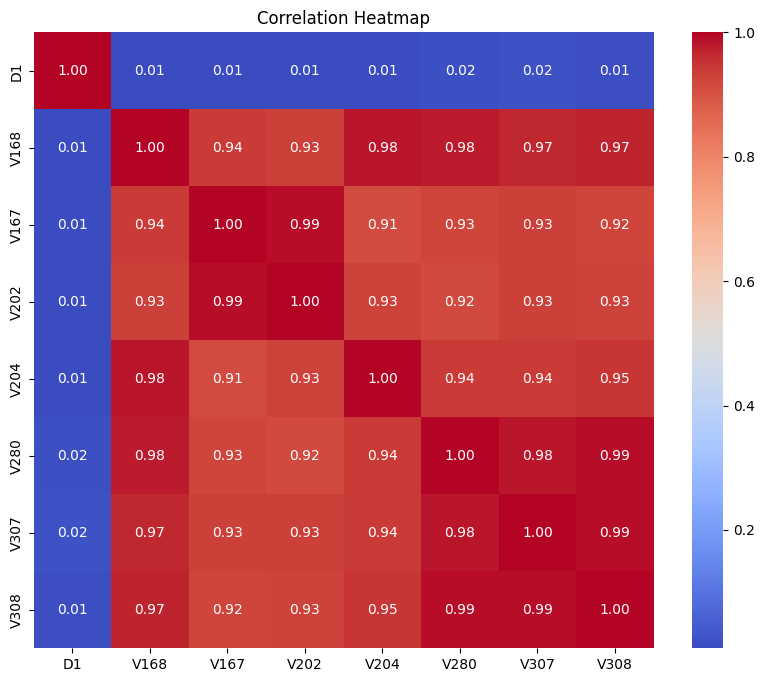

In [ ]:

cols_to_plot = ['D1','V168', 'V167', 'V202', 'V204', 'V280', 'V307', 'V308']

# Check if all columns exist in the DataFrame
if not all(col in new_df2.columns for col in cols_to_plot):
    missing_cols = set(cols_to_plot) - set(new_df2.columns)
    print(f"Warning: The following columns are not present in the DataFrame: {missing_cols}")
    # Remove missing columns from the list
    cols_to_plot = [col for col in cols_to_plot if col in new_df2.columns]
correlation_matrix = new_df2[cols_to_plot].corr()

plt.figure(figsize=(10, 8))  # Adjust figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
new_PCA_list = ['V168', 'V167', 'V202', 'V204', 'V280', 'V307', 'V308']
V_X = new_df2.loc[:,new_PCA_list]
scaler = StandardScaler()
pca = PCA(n_components=1)
pca.fit(scaler.fit_transform(V_X))
V_PCA = pca.transform(V_X)

In [ ]:
df_drop = df_drop.copy().drop(columns = new_PCA_list)
new_df2 = new_df2.copy().drop(columns = new_PCA_list)
df_drop['V_PCA'] = V_PCA
new_df2['V_PCA'] = V_PCA

In [ ]:
new_df2.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'P_emaildomain', 'R_emaildomain', 'D1', 'V170', 'V171', 'V203', 'V217',
       'V218', 'V219', 'V221', 'V222', 'V224', 'V228', 'V229', 'V230', 'V231',
       'V232', 'V233', 'V245', 'V250', 'V251', 'V255', 'V256', 'V258', 'V259',
       'V261', 'V262', 'V263', 'V264', 'V265', 'V267', 'V273', 'V274', 'V275',
       'V282', 'V283', 'id_01', 'id_02', 'id_05', 'id_06', 'id_13', 'id_15',
       'id_16', 'id_17', 'id_19', 'id_20', 'id_28', 'id_29', 'id_31', 'id_35',
       'id_37', 'id_38', 'DeviceType', 'C_PCA', 'V_PCA'],
      dtype='object')

In [ ]:
new_df2.to_csv('Dataset_with_filling_nan.csv')

## Outerlier detection

#### IQR detects outliers

In [ ]:
def find_outlier_indices(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_indices = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)].index
    return outlier_indices


In [ ]:
def draw_outlier_boxplot(df, feature):
    fig, ax = plt.subplots(figsize=(6, 20))
    ax.boxplot(x=df[feature])
    ax.set_title(f'Box Plot of {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Value')
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_indices = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)].index
    outliers = df.loc[outlier_indices, feature]
    # ax.scatter(outliers.index, outliers, color='red', label='Outliers')
    ax.legend()
    plt.show()


In [ ]:
outliers_map = {}
numerical_col = new_df2.columns[new_df2.dtypes != 'object']
numerical_col_NAN = [col for col in numerical_col if col != 'isFraud']

for col in numerical_col_NAN:
    outliers = find_outlier_indices(new_df2, col)
    outliers_map[col] = outliers
    # print(f'Number of outliers in {col}: {len(outliers)}')

In [ ]:
new_df2.shape[0]

144233

In [ ]:
for k,v in outliers_map.items():
    if v.shape[0] > 0:
        print(f'Number of outliers in {k}: {len(v)/144233}')
        # draw_outlier_boxplot(new_df2, k)

Number of outliers in TransactionAmt: 0.060014005116720864
Number of outliers in D1: 0.20650613937171106
Number of outliers in V170: 0.28036579700900627
Number of outliers in V171: 0.314095941982764
Number of outliers in V203: 0.180541207629322
Number of outliers in V217: 0.2401392191800767
Number of outliers in V218: 0.11216573183668092
Number of outliers in V219: 0.0905548660847379
Number of outliers in V221: 0.4198831058079635
Number of outliers in V222: 0.43673084522959377
Number of outliers in V224: 0.15760609569238662
Number of outliers in V228: 0.1625286862229864
Number of outliers in V229: 0.22428986431676523
Number of outliers in V230: 0.19057358579520636
Number of outliers in V231: 0.14638813586349864
Number of outliers in V232: 0.16665395575215103
Number of outliers in V233: 0.15606691949831175
Number of outliers in V245: 0.27604639714905743
Number of outliers in V250: 0.24505487648457705
Number of outliers in V251: 0.24826496016861607
Number of outliers in V255: 0.246774316

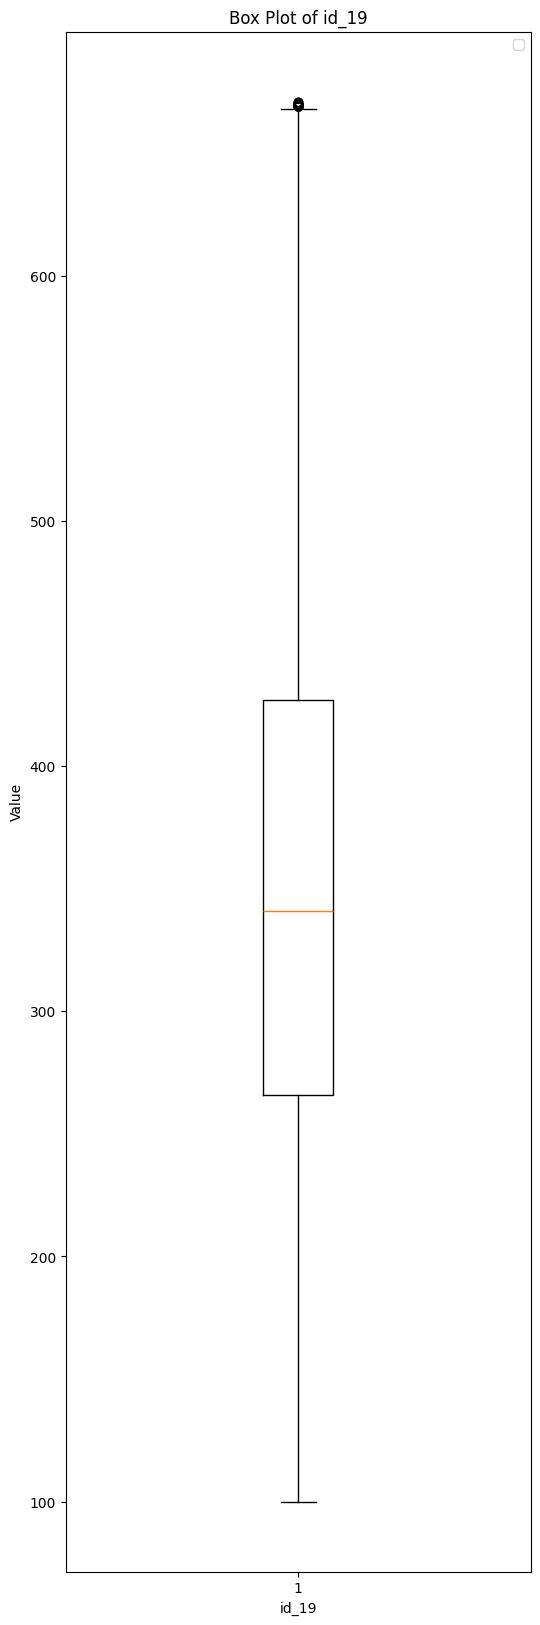

In [ ]:
draw_outlier_boxplot(new_df2, 'id_19')

### Z-score outlier detection

In [ ]:
def detect_outliers_zscore(df, feature, threshold=3):
  z_scores = np.abs((df[feature] - df[feature].mean()) / df[feature].std())
  outlier_indices = df[z_scores > threshold].index
  return outlier_indices

outliers_zscore_map = {}
for col in numerical_col_NAN:
    outliers_zscore = detect_outliers_zscore(new_df2, col)
    outliers_zscore_map[col] = outliers_zscore
    # print(f'Number of outliers in {col}: {len(outliers_zscore)}')

for k,v in outliers_zscore_map.items():
    if v.shape[0] > 0:
        print(f'Number of outliers in {k} using Z-score: {len(v)/144233}')


Number of outliers in TransactionAmt using Z-score: 0.018768243051174142
Number of outliers in card3 using Z-score: 0.005726844758134408
Number of outliers in D1 using Z-score: 0.04227881275436273
Number of outliers in V170 using Z-score: 0.01554429291493625
Number of outliers in V171 using Z-score: 0.02262311676246074
Number of outliers in V203 using Z-score: 0.011883549534433867
Number of outliers in V217 using Z-score: 0.0025444939784931325
Number of outliers in V218 using Z-score: 0.0037439420936956173
Number of outliers in V219 using Z-score: 0.0031892840057407114
Number of outliers in V221 using Z-score: 0.0075433499961867255
Number of outliers in V222 using Z-score: 0.00779987936186587
Number of outliers in V224 using Z-score: 0.00628843607218875
Number of outliers in V228 using Z-score: 0.01586322131551032
Number of outliers in V229 using Z-score: 0.00560897991444399
Number of outliers in V230 using Z-score: 0.011987547925925412
Number of outliers in V231 using Z-score: 0.00255

In [ ]:
outliers_index_list = []
for col in numerical_col_NAN:
    outliers_zscore = detect_outliers_zscore(new_df2, col)
    outliers_zscore_map[col] = outliers_zscore
    outliers_index_list.extend(outliers_zscore)
unique_outlier_index = set(outliers_index_list)

In [ ]:
new_df3 = new_df2.drop(list(unique_outlier_index))

In [ ]:
# after delete z-score detected outliers
new_df3['isFraud'].value_counts(dropna=False, normalize = True)

,proportion
isFraud,
0,0.938582
1,0.061418


### Isolation Forest

### DBScan

In [ ]:
"""numerical_col = new_df2.columns[new_df2.dtypes != 'object']
new_column = [col for col in numerical_col if col != 'isFraud']
len(new_column)
features_for_dbscan = new_column[1:]
# Fit DBSCAN
dbscan = DBSCAN(eps=3, min_samples=5)
dbscan.fit(new_df2[features_for_dbscan])
new_df2['dbscan_labels'] = dbscan.labels_


core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True
labels = dbscan.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
unique_labels = set(labels)

distances = np.full(new_df2.shape[0], np.nan)
for i in range(len(dbscan.core_sample_indices_)):
    distances[dbscan.core_sample_indices_[i]] = dbscan.components_[i, 0]  # Or another feature

valid_distance = distances[~np.isnan(distances)]
if valid_distance > 0:
    max_distance = valid_distance.max()
else:
    max_distance = 1
outlier_scores = -distances
outlier_scores[np.isnan(outlier_scores)] = -max_distance

new_df2['dbscan_outlier_score'] = outlier_scores

print(new_df2.head())

def detect_outliers_dbscan(df, feature, eps=1, min_samples=5):
  dbscan = DBSCAN(eps=eps, min_samples=min_samples)
  labels = dbscan.fit_predict(np.array(df[feature]).reshape(-1, 1))

  outlier_indices = df[labels == -1].index
  return outlier_indices


outliers_dbscan_map = {}
for col in numerical_col_NAN:
    outliers_dbscan = detect_outliers_dbscan(new_df2,col)
    outliers_dbscan_map[col] = outliers_dbscan
    # print(f'Number of outliers in {col}: {len(outliers_zscore)}')

for k,v in outliers_dbscan_map.items():
    if v.shape[0] > 0:
        print(f'Number of outliers in {k} using DBScan: {len(v)/144233}')"""


"numerical_col = new_df2.columns[new_df2.dtypes != 'object']\nnew_column = [col for col in numerical_col if col != 'isFraud']\nlen(new_column)\nfeatures_for_dbscan = new_column[1:]\n# Fit DBSCAN\ndbscan = DBSCAN(eps=3, min_samples=5)\ndbscan.fit(new_df2[features_for_dbscan])\nnew_df2['dbscan_labels'] = dbscan.labels_\n\n\ncore_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)\ncore_samples_mask[dbscan.core_sample_indices_] = True\nlabels = dbscan.labels_\nn_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)\nn_noise_ = list(labels).count(-1)\nunique_labels = set(labels)\n\ndistances = np.full(new_df2.shape[0], np.nan)\nfor i in range(len(dbscan.core_sample_indices_)):\n    distances[dbscan.core_sample_indices_[i]] = dbscan.components_[i, 0]  # Or another feature\n\nvalid_distance = distances[~np.isnan(distances)]\nif valid_distance > 0:\n    max_distance = valid_distance.max()\nelse:\n    max_distance = 1\noutlier_scores = -distances\noutlier_scores[np.isnan(outlier_score

In [ ]:
# Isolation Forest outlier detection
"""temp_df2 = new_df2.copy()
temp_df2 = temp_df2.drop('isFraud',axis=1)
numerical_features = temp_df2.select_dtypes(include=np.number).columns
model = IsolationForest(contamination='auto', random_state=42)
model.fit(temp_df2[numerical_features])
outlier_predictions = model.predict(temp_df2[numerical_features])
temp_df2['outlier_prediction'] = outlier_predictions
outliers = temp_df2[temp_df2['outlier_prediction'] == -1]
print(f"Number of outliers detected: {len(outliers)}")
transaction_id_outliers = temp_df2['TransactionID'][temp_df2['outlier_prediction'] == -1]
transaction_id_fraud = new_df2['TransactionID'][new_df2['isFraud'] == 1]
common_transaction_ids = len(set(transaction_id_outliers) & set(transaction_id_fraud))
print(f"Number of transaction IDs that are both fraud and outliers: {common_transaction_ids/len(transaction_id_fraud)}")"""

'temp_df2 = new_df2.copy()\ntemp_df2 = temp_df2.drop(\'isFraud\',axis=1)\nnumerical_features = temp_df2.select_dtypes(include=np.number).columns\nmodel = IsolationForest(contamination=\'auto\', random_state=42)\nmodel.fit(temp_df2[numerical_features])\noutlier_predictions = model.predict(temp_df2[numerical_features])\ntemp_df2[\'outlier_prediction\'] = outlier_predictions\noutliers = temp_df2[temp_df2[\'outlier_prediction\'] == -1]\nprint(f"Number of outliers detected: {len(outliers)}")\ntransaction_id_outliers = temp_df2[\'TransactionID\'][temp_df2[\'outlier_prediction\'] == -1]\ntransaction_id_fraud = new_df2[\'TransactionID\'][new_df2[\'isFraud\'] == 1]\ncommon_transaction_ids = len(set(transaction_id_outliers) & set(transaction_id_fraud))\nprint(f"Number of transaction IDs that are both fraud and outliers: {common_transaction_ids/len(transaction_id_fraud)}")'

## Encoding Categorical data

### Catboost Encoding

In [ ]:
new_categorical = new_df2.columns[new_df2.dtypes == 'object']
catboost_encoder = CatBoostEncoder()
encode = catboost_encoder.fit_transform(new_df2[new_categorical], new_df2['isFraud'])
df_cat = new_df2.copy()
df_cat[new_categorical] = encode

### Target Encoding

In [ ]:
def target_encoding(df, target_column, categorical_columns):
  df_encoded = df.copy()
  for col in categorical_columns:
    if col != target_column:
      mapping = df.groupby(col)[target_column].mean()
      df_encoded[col] = df_encoded[col].map(mapping)
  return df_encoded

df_target = target_encoding(new_df2, 'isFraud', new_categorical)

new_df4 is using target encoding to encode categorical features

### Onehot Encoding

In [ ]:
df_onehot = pd.get_dummies(new_df2, columns=new_categorical, dummy_na=False)

# Model Training

In [ ]:
def X_y_train_test(df):
    X = df.sort_values('TransactionDT').drop((['isFraud', 'TransactionDT', 'TransactionID']), axis=1)
    y = list(df.sort_values('TransactionDT')['isFraud'])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_scaled_train = scaler.fit_transform(X_train)
    X_scaled_test = scaler.fit_transform(X_test)
    return (X_scaled_train, X_scaled_test, y_train, y_test)

In [ ]:
def show_performance(y_test, y_pred):
    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print("Recall:", recall)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("F1-score:", f1)
    print("MCC:", matthews_corrcoef(y_test, y_pred))

    print('')

    precision_l, recall_l, thresholds = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall_l, precision_l)

    print("AUC-ROC:", roc_auc_score(y_test, y_pred))
    print("AUC-PR:", pr_auc)

In [ ]:
def visual_performance(y_test, y_pred, y_pred_proba):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(3, 2))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    axes[0].plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})', lw=2)
    axes[0].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
    axes[0].set_xlim([0.0, 1.0])
    axes[0].set_ylim([0.0, 1.05])
    axes[0].set_xlabel('False Positive Rate (FPR)')
    axes[0].set_ylabel('True Positive Rate (TPR)')
    axes[0].set_title('Receiver Operating Characteristic (ROC) Curve')
    axes[0].legend(loc='lower right')
    axes[0].grid(alpha=0.3)

    axes[1].plot(recall, precision, label=f'Precision-Recall Curve (AUC = {pr_auc:.2f})', lw=2)
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_title('Precision-Recall Curve')
    axes[1].legend(loc='lower left')
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

In [ ]:
def show_parameter_scores(search_model):
    results = search_model.cv_results_
    scores_df = pd.DataFrame({
        'params': results['params'],
        'mean_test_score': results['mean_test_score'],
        'std_test_score': results['std_test_score'],
        'rank_test_score': results['rank_test_score']
    })
    scores_df = scores_df.sort_values(by='rank_test_score')
    return scores_df

In [ ]:
def draw_parameter_scores(scores_df):
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(scores_df)), scores_df['mean_test_score'], tick_label=scores_df['params'], align='center')
    plt.xticks(rotation=90)
    plt.ylabel('Mean Test Score')
    plt.xlabel('Parameter Set')
    plt.title('Scores for Parameter Sets in HalvingGridSearchCV')
    plt.tight_layout()
    plt.show()


In [ ]:
def extract_and_plot_parameter_distributions(scores_df, top_n=100):
  param_values = [params for params in scores_df['params'].iloc[:top_n]]
  param_dict = {}
  for params in param_values:
      for key, value in params.items():
          if key not in param_dict:
              param_dict[key] = []
          param_dict[key].append(value)
  for param_name, values in param_dict.items():
      plt.figure(figsize=(8, 6))
      sns.histplot(values)
      plt.title(f'Distribution of {param_name}')
      plt.xlabel(param_name)
      plt.ylabel('Frequency')
      plt.show()



In [ ]:
def draw_3d_plot(score_df, parameter_col, target_col):
    grouped_df = score_df.groupby(parameter_col, as_index=False)[target_col].mean()
    X = grouped_df[parameter_col[0]]
    Y = grouped_df[parameter_col[1]]
    Z = grouped_df[parameter_col[2]]
    T = grouped_df[target_col]
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(X, Y, Z, c=T, cmap='viridis', s=100)
    ax.set_xlabel(parameter_col[0].replace('sgd__', ''))
    ax.set_ylabel(parameter_col[1].replace('sgd__', ''))
    ax.set_zlabel(parameter_col[2].replace('sgd__', ''))
    ax.set_title('3D Plot of Mean Test Score')
    cbar = fig.colorbar(scatter, ax=ax, pad=0.1)
    cbar.set_label('Mean Test Score', rotation=270, labelpad=15)
    plt.show()

In [ ]:
para_model = {}

#### SVM

##### target encoding

In [ ]:
# Custom scorer for AUC-ROC, Sensitivity, Specificity
def sensitivity(y_true, y_pred):
    return recall_score(y_true, y_pred)
def specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)
def precision(y_true, y_pred):
    return precision_score(y_true, y_pred)
def matthews_corrcoef_function(y_true, y_pred):
    return matthews_corrcoef(y_true, y_pred)
def avg_precision(y_true, y_pred):
    return average_precision_score(y_true, y_pred)
scoring = {
    'AUC of ROC': 'roc_auc',
    'MCC': make_scorer(matthews_corrcoef_function),
    'Sensitivity': make_scorer(sensitivity),
    'Specificity': make_scorer(specificity),
    'Precision': make_scorer(precision),
    'Average Precision': make_scorer(avg_precision)
}

In [ ]:
X_train, X_test, y_train, y_test = X_y_train_test(df_target)

In [ ]:
param_svm = {
    'pca__n_components': [5, 10, 15, 20, 25],
    'sgd__alpha': [0.0001, 0.001, 0.01,0.005, 0.0005],
    'sgd__learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'sgd__max_iter': [500, 1000, 2000, 3000],
    'sgd__eta0': [0.001, 0.01, 0.1],
    'sgd__tol': [0.0001, 0.001, 0.01]
}
pipeline = Pipeline([
    ('pca', PCA()),
    ('sgd', SGDClassifier(random_state=42, penalty='elasticnet', loss='hinge',class_weight='balanced'))
])

###### random search

In [ ]:
random_search = RandomizedSearchCV(pipeline, param_svm, n_iter=10, cv=5, scoring=scoring, random_state=42,refit='MCC')
random_search.fit(X_train, y_train)
print("Best Hyperparameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

Best Hyperparameters: {'sgd__tol': 0.0001, 'sgd__max_iter': 2000, 'sgd__learning_rate': 'constant', 'sgd__eta0': 0.001, 'sgd__alpha': 0.01, 'pca__n_components': 25}
Best Score: 0.31428912255305147


Recall: [1.         0.68258179 0.        ]
Accuracy: 0.7766145526397892
Precision: [0.0784137  0.21237964 1.        ]
F1-score: 0.3239613932018464
AUC-ROC: 0.7335985853227233
MCC: 0.2892691373303792
PR-AUC: 0.45992568247890503


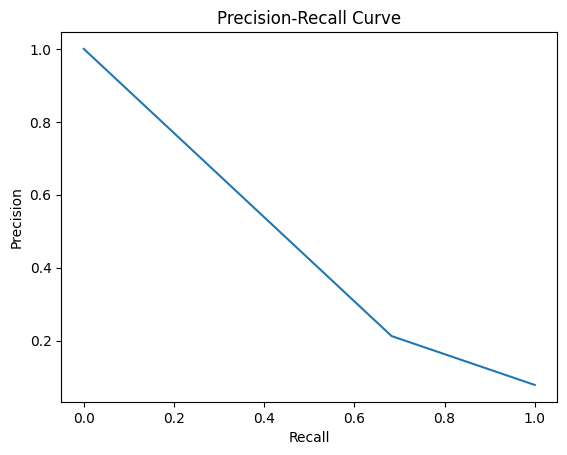

In [ ]:
best_sgd_classifier1 = random_search.best_estimator_
y_pred = best_sgd_classifier1.predict(X_test)
show_performance(y_test, y_pred)

In [ ]:
random_search = RandomizedSearchCV(pipeline, param_svm, n_iter=10, cv=5, scoring=scoring, random_state=42,refit='Average Precision')
random_search.fit(X_train, y_train)
print("Best Hyperparameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

Best Hyperparameters: {'sgd__tol': 0.0001, 'sgd__max_iter': 2000, 'sgd__learning_rate': 'constant', 'sgd__eta0': 0.001, 'sgd__alpha': 0.01, 'pca__n_components': 25}
Best Score: 0.18476534990620003


Recall: [1.         0.68258179 0.        ]
Accuracy: 0.7766145526397892
Precision: [0.0784137  0.21237964 1.        ]
F1-score: 0.3239613932018464
AUC-ROC: 0.7335985853227233
MCC: 0.2892691373303792
PR-AUC: 0.45992568247890503


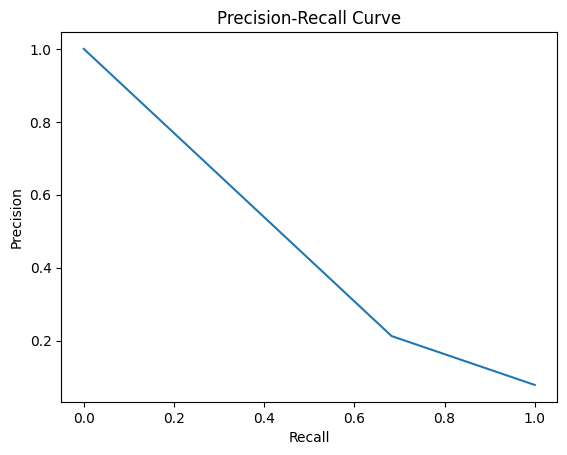

In [ ]:
best_sgd_classifier = random_search.best_estimator_
y_pred = best_sgd_classifier.predict(X_test)
show_performance(y_test, y_pred)
para_model['SVM_target_random'] = best_sgd_classifier
print(f"Proportion of y_pred:{sum(y_pred)/len(y_pred) }")
print(f"Proportion of y_test:{sum(y_test)/len(y_test)}")


Proportion of y_pred:0.25201927410129304
Proportion of y_test:0.07841369986480397


###### HalvingGrid Search

In [ ]:
"""halving_search = HalvingGridSearchCV(
    pipeline,
    param_grid=param_svm,
    cv=5,
    scoring='average_precision',
    random_state=42,
    factor=2,
    resource='n_samples'
)
halving_search.fit(X_train, y_train)
best_sgd_classifier = halving_search.best_estimator_
y_pred = best_sgd_classifier.predict(X_test)
para_model['SVM_target_halving'] = best_sgd_classifier
show_performance(y_test, y_pred)
score_df = show_parameter_scores(halving_search)
extract_and_plot_parameter_distributions(score_df)
expanded_params = pd.json_normalize(score_df['params'])
score_df = pd.concat([score_df.drop(columns=['params']), expanded_params], axis=1)
parameter_col = ['sgd__alpha', 'sgd__eta0','sgd__tol']
target_col = 'mean_test_score'
draw_3d_plot(score_df, parameter_col, target_col)"""

HalvingGridSearchCV(estimator=Pipeline(steps=[('pca', PCA()),
                                              ('sgd',
                                               SGDClassifier(class_weight='balanced',
                                                             penalty='elasticnet',
                                                             random_state=42))]),
                    factor=2,
                    param_grid={'pca__n_components': [5, 10, 15, 20, 25],
                                'sgd__alpha': [0.0001, 0.001, 0.01, 0.005,
                                               0.0005],
                                'sgd__eta0': [0.001, 0.01, 0.1],
                                'sgd__learning_rate': ['constant', 'optimal',
                                                       'invscaling',
                                                       'adaptive'],
                                'sgd__max_iter': [500, 1000, 2000, 3000],
                                'sgd__tol': [0.0001, 0.001, 0.01]},
                    random_state=42, scoring='average_precision')

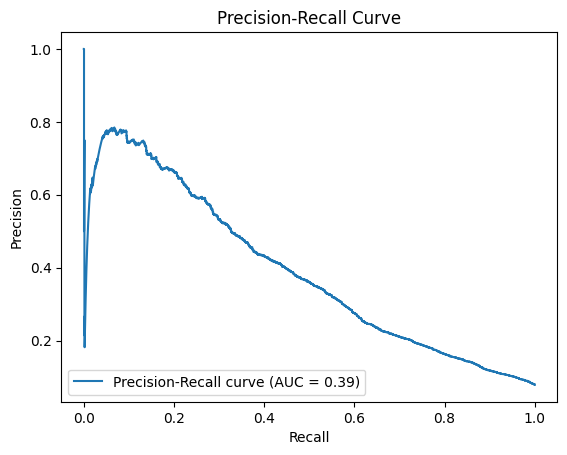

In [ ]:
"""y_pred_proba = best_sgd_classifier.decision_function(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)
plt.plot(recall, precision, label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()"""

##### catboost in SVM

In [ ]:
X_train, X_test, y_train, y_test = X_y_train_test(df_cat)

###### RandomSearch

In [ ]:
random_search = RandomizedSearchCV(pipeline, param_svm, n_iter=10, cv=5, scoring='recall', random_state=42)
random_search.fit(X_train, y_train)
print("Best Hyperparameters:", random_search.best_params_)
print("Best Recall/TPR Score:", random_search.best_score_)
best_sgd_classifier = random_search.best_estimator_
y_pred = best_sgd_classifier.predict(X_test)
para_model['SVM_catboost_target'] = best_sgd_classifier
show_performance(y_test, y_pred)

###### HalvingGrid Search

In [ ]:
halving_search = HalvingGridSearchCV(
    pipeline,
    param_grid=param_svm,
    cv=5,
    scoring='average_precision',
    random_state=42,
    factor=2,
    resource='n_samples'
)
halving_search.fit(X_train, y_train)

HalvingGridSearchCV(estimator=Pipeline(steps=[('pca', PCA()),
                                              ('sgd',
                                               SGDClassifier(class_weight='balanced',
                                                             penalty='elasticnet',
                                                             random_state=42))]),
                    factor=2,
                    param_grid={'pca__n_components': [5, 10, 15, 20, 25],
                                'sgd__alpha': [0.0001, 0.001, 0.01, 0.005,
                                               0.0005],
                                'sgd__eta0': [0.001, 0.01, 0.1],
                                'sgd__learning_rate': ['constant', 'optimal',
                                                       'invscaling',
                                                       'adaptive'],
                                'sgd__max_iter': [500, 1000, 2000, 3000],
                                'sgd__tol': [0.0001, 0.001, 0.01]},
                    random_state=42, scoring='average_precision')

In [ ]:
best_sgd_classifier = halving_search.best_estimator_
y_pred = best_sgd_classifier.predict(X_test)
para_model['SVM_cat_halving'] = best_sgd_classifier
show_performance(y_test, y_pred)

Recall: [1.         0.67904509 0.        ]
Accuracy: 0.7881928796755295
Precision: [0.0784137  0.22196532 1.        ]
F1-score: 0.3345676323241124
PR-AUC: 0.4630888362587965


In [ ]:
score_df = show_parameter_scores(halving_search)
score_df.head(20)

,params,mean_test_score,std_test_score,rank_test_score
3241,"{'pca__n_components': 25, 'sgd__alpha': 0.01, ...",0.63303,0.38913,1
2956,"{'pca__n_components': 25, 'sgd__alpha': 0.0001...",0.63303,0.38913,1
2953,"{'pca__n_components': 25, 'sgd__alpha': 0.0001...",0.63303,0.38913,1
2927,"{'pca__n_components': 25, 'sgd__alpha': 0.0001...",0.63303,0.38913,1
2924,"{'pca__n_components': 25, 'sgd__alpha': 0.0001...",0.63303,0.38913,1
2921,"{'pca__n_components': 25, 'sgd__alpha': 0.0001...",0.63303,0.38913,1
2918,"{'pca__n_components': 25, 'sgd__alpha': 0.0001...",0.63303,0.38913,1
2891,"{'pca__n_components': 25, 'sgd__alpha': 0.0001...",0.63303,0.38913,1
2888,"{'pca__n_components': 25, 'sgd__alpha': 0.0001...",0.63303,0.38913,1
2885,"{'pca__n_components': 25, 'sgd__alpha': 0.0001...",0.63303,0.38913,1


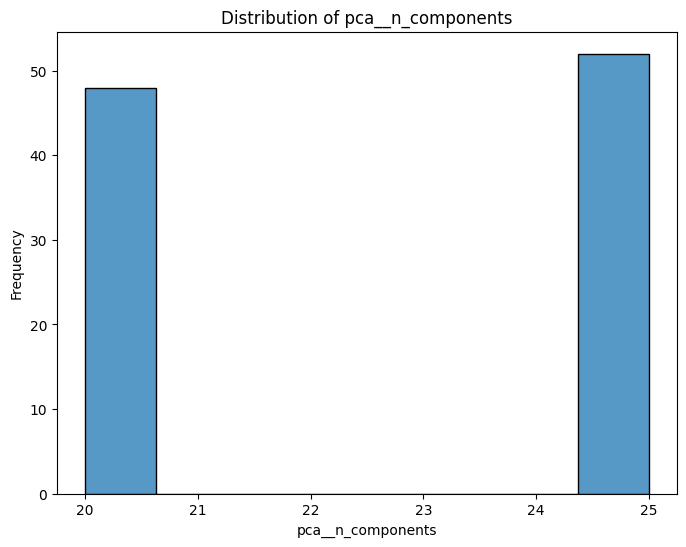

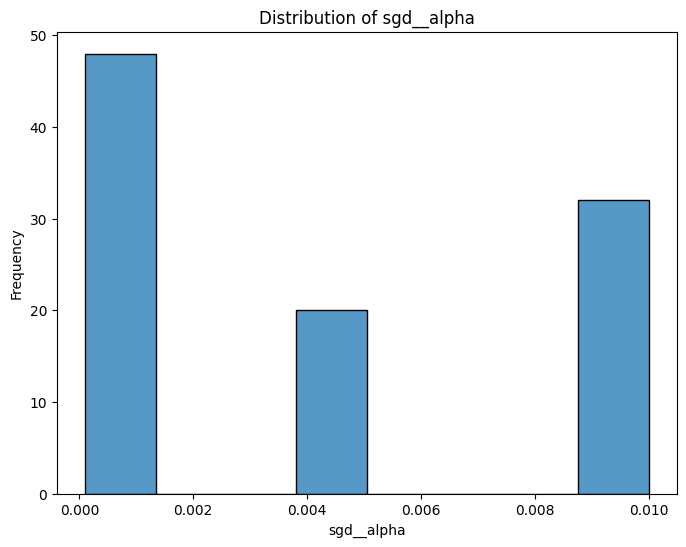

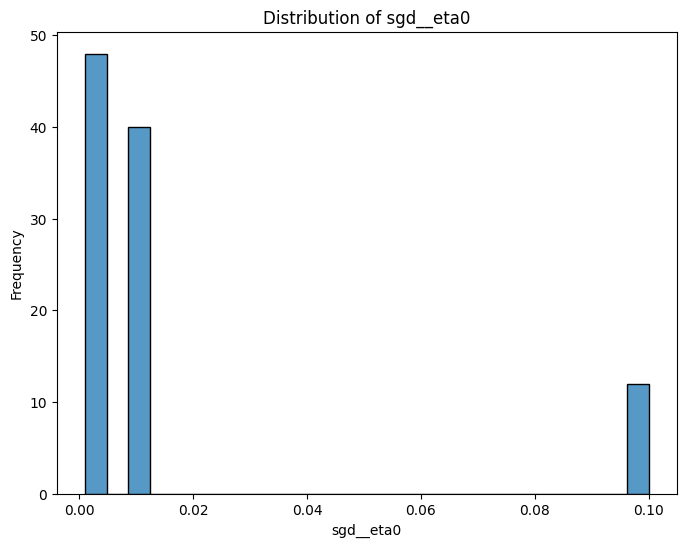

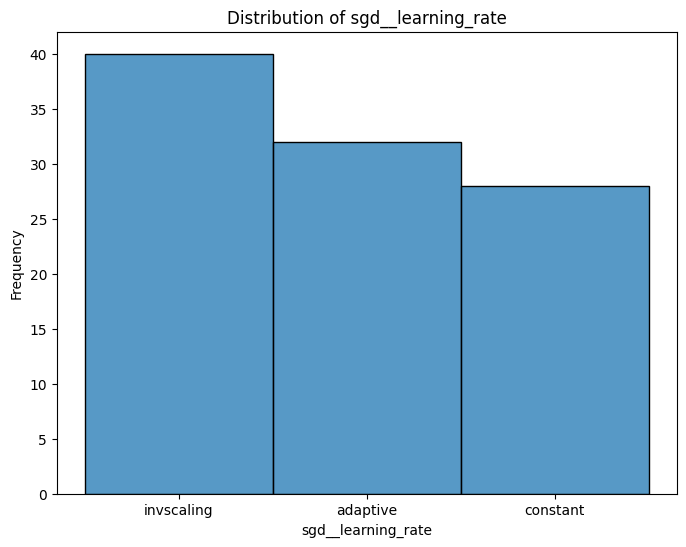

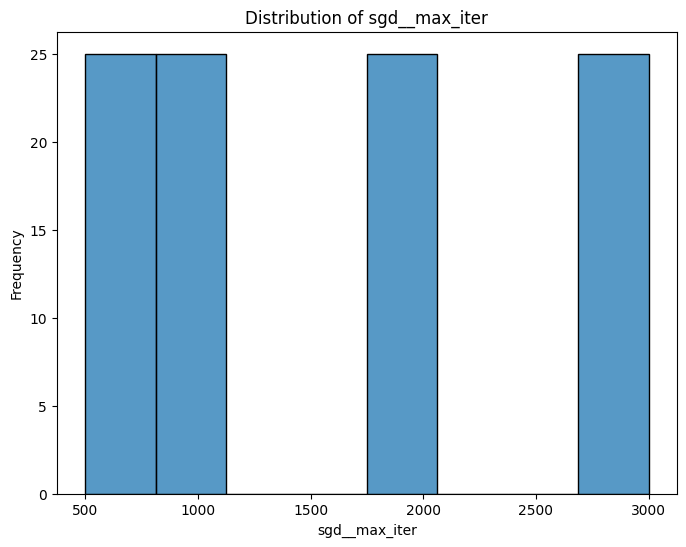

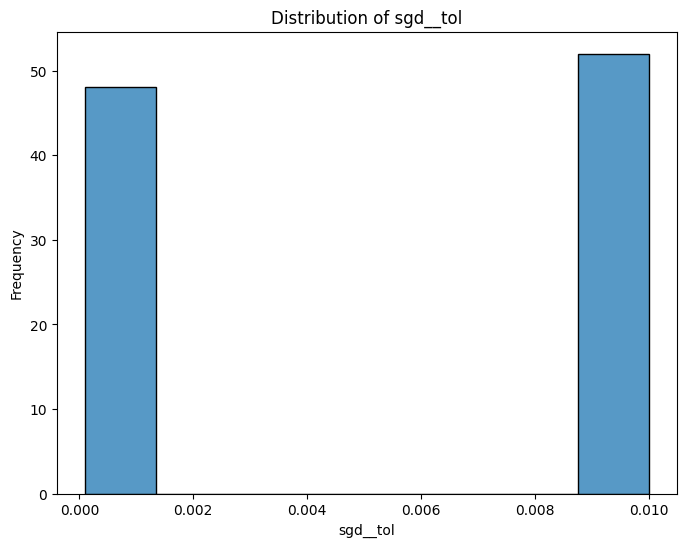

In [ ]:
extract_and_plot_parameter_distributions(score_df)

In [ ]:
expanded_params = pd.json_normalize(score_df['params'])
score_df = pd.concat([score_df.drop(columns=['params']), expanded_params], axis=1)
score_df

,mean_test_score,std_test_score,rank_test_score,pca__n_components,sgd__alpha,sgd__eta0,sgd__learning_rate,sgd__max_iter,sgd__tol
3278,0.589697,0.371440,1,15,0.0005,0.010,adaptive,2000,0.0010
3235,0.589697,0.371440,1,10,0.0100,0.100,optimal,2000,0.0001
3236,0.589697,0.371440,1,10,0.0100,0.100,optimal,3000,0.0010
3279,0.589697,0.371440,1,15,0.0005,0.010,adaptive,2000,0.0001
3237,0.589697,0.371440,1,10,0.0100,0.100,optimal,1000,0.0100
...,...,...,...,...,...,...,...,...,...
66,0.158375,0.042295,7156,20,0.0100,0.010,optimal,2000,0.0001
67,0.158375,0.042295,7156,20,0.0100,0.001,optimal,3000,0.0010
68,0.158375,0.042295,7156,20,0.0100,0.001,optimal,3000,0.0001
23,0.158375,0.042295,7156,25,0.0100,0.100,optimal,1000,0.0010


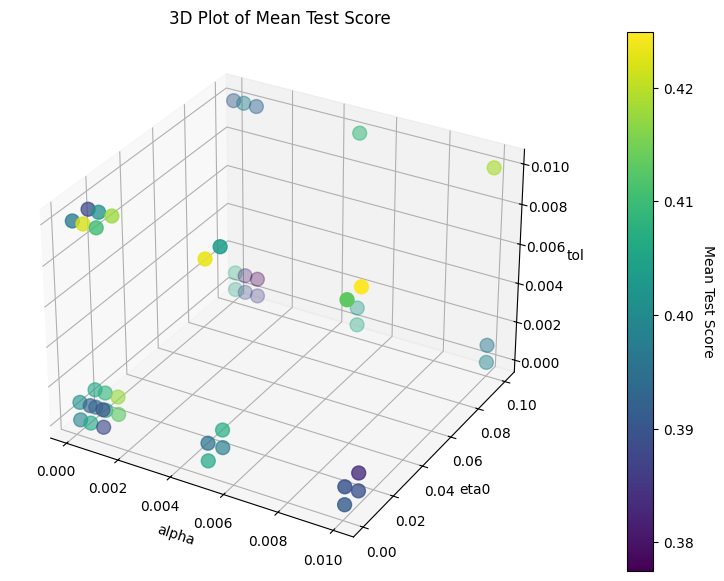

In [ ]:
parameter_col = ['sgd__alpha', 'sgd__eta0','sgd__tol']
target_col = 'mean_test_score'
draw_3d_plot(score_df, parameter_col, target_col)

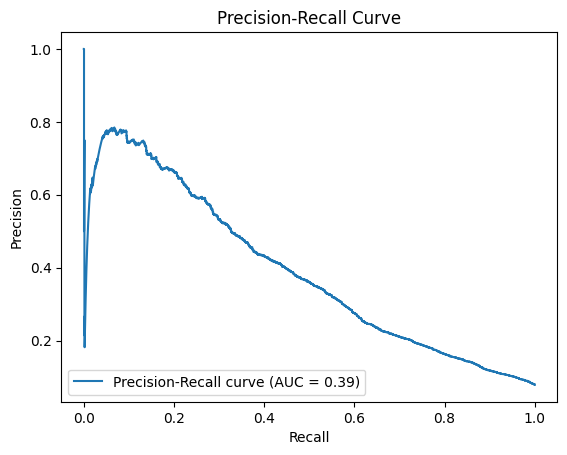

In [ ]:
y_pred_proba = best_sgd_classifier.decision_function(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)
plt.plot(recall, precision, label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

#### LightGBM

###### Using SMOTE to balance our dataset

In [ ]:
oversample = SMOTE()
X = df_target.drop('isFraud', axis=1)
y = df_target['isFraud']
X_resampled, y_resampled = oversample.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

##### target encoding

In [ ]:
param_lgm = {
    'pca__n_components': [10, 20, 30],
    'lgbm__num_leaves': [31, 50, 80],
    'lgbm__n_estimators': [150, 200],
    'lgbm__min_child_samples': [5, 10],
    'lgbm__max_depth': [-1, 10, 20],
    'lgbm__learning_rate': [0.1, 0.2],
    'lgbm__feature_fraction': [1.0, 0.8],
    'lgbm__bagging_freq': [5, 10],
    'lgbm__bagging_fraction': [1.0, 0.8],
    'lgbm__verbose': [-1],  # Set to -1 to suppress warnings
}
pipeline = Pipeline([
    ('pca', PCA()),
    ('lgbm', lgb.LGBMClassifier())
])

Best Hyperparameters: {'pca__n_components': 30, 'lgbm__verbose': -1, 'lgbm__num_leaves': 50, 'lgbm__n_estimators': 200, 'lgbm__min_child_samples': 10, 'lgbm__max_depth': 20, 'lgbm__learning_rate': 0.2, 'lgbm__feature_fraction': 0.8, 'lgbm__bagging_freq': 10, 'lgbm__bagging_fraction': 1.0}
Best Recall/TPR Score: 0.9879966721331723
Recall: [1.         0.94556452 0.        ]
Accuracy: 0.9469585825527593
Precision: [0.50378061 0.94896583 1.        ]
F1-score: 0.947262118491921
AUC-ROC: 0.9469692037092738
MCC: 0.893919826226695
PR-AUC: 0.9609769424140909


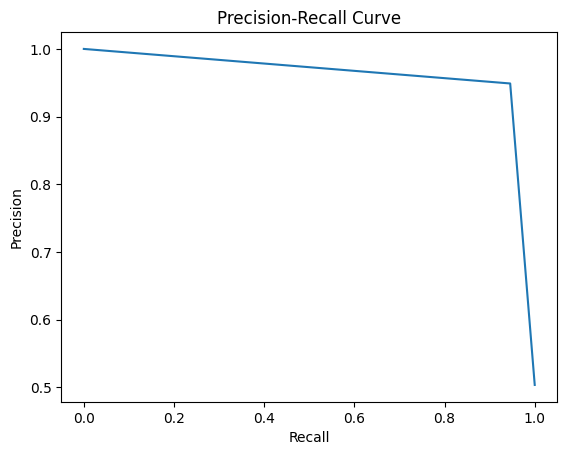

In [ ]:
# train_data = lgb.Dataset(X_train, label=y_train)
# test_data = lgb.Dataset(X_test, label=y_test)
random_search = RandomizedSearchCV(pipeline, param_lgm, n_iter=10, cv=5, scoring='average_precision', random_state=42)
random_search.fit(X_train,y_train)
print("Best Hyperparameters:", random_search.best_params_)
print("Best Recall/TPR Score:", random_search.best_score_)
best_lgbm_classifier = random_search.best_estimator_
y_pred = best_lgbm_classifier.predict(X_test)
para_model['LGBM_target'] = best_lgbm_classifier
show_performance(y_test, y_pred)

###### Halving Grid Search

In [ ]:
halving_search = HalvingGridSearchCV(
    pipeline,
    param_grid=param_lgm,
    cv=5,
    scoring='average_precision',
    random_state=42,
    factor=2,
    resource='n_samples'
)
halving_search.fit(X_train, y_train)

HalvingGridSearchCV(estimator=Pipeline(steps=[('pca', PCA()),
                                              ('lgbm', LGBMClassifier())]),
                    factor=2,
                    param_grid={'lgbm__bagging_fraction': [1.0, 0.8],
                                'lgbm__bagging_freq': [5, 10],
                                'lgbm__feature_fraction': [1.0, 0.8],
                                'lgbm__learning_rate': [0.1, 0.2],
                                'lgbm__max_depth': [-1, 10, 20],
                                'lgbm__min_child_samples': [5, 10],
                                'lgbm__n_estimators': [150, 200],
                                'lgbm__num_leaves': [31, 50, 80],
                                'lgbm__verbose': [-1],
                                'pca__n_components': [10, 20, 30]},
                    random_state=42, scoring='average_precision')

Best Hyperparameters: {'pca__n_components': 30, 'lgbm__verbose': -1, 'lgbm__num_leaves': 50, 'lgbm__n_estimators': 200, 'lgbm__min_child_samples': 10, 'lgbm__max_depth': 20, 'lgbm__learning_rate': 0.2, 'lgbm__feature_fraction': 0.8, 'lgbm__bagging_freq': 10, 'lgbm__bagging_fraction': 1.0}
Best Score: 0.9879966721331723
Recall: [1.         0.94556452 0.        ]
Accuracy: 0.9469585825527593
Precision: [0.50378061 0.94896583 1.        ]
F1-score: 0.947262118491921
AUC-ROC: 0.9469692037092738
MCC: 0.893919826226695
PR-AUC: 0.9609769424140909


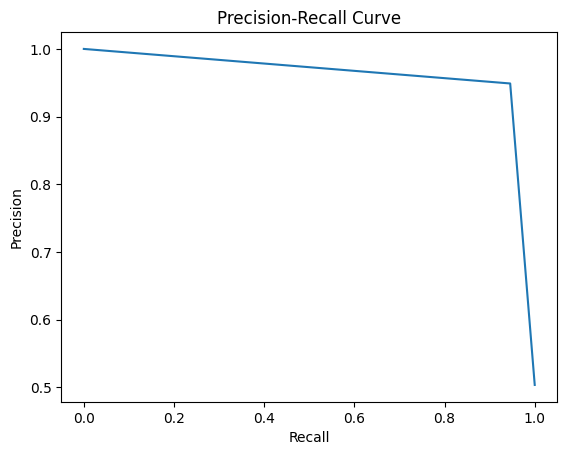

In [ ]:
print("Best Hyperparameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)
best_lgbm_classifier = random_search.best_estimator_
y_pred = best_lgbm_classifier.predict(X_test)
para_model['LGBM_target_halving'] = best_lgbm_classifier
show_performance(y_test, y_pred)

##### catboost encoding

In [ ]:
oversample = SMOTE()
X = df_cat.drop('isFraud', axis=1)
y = df_target['isFraud']
X_resampled, y_resampled = oversample.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

In [ ]:
X_train, X_test, y_train, y_test = X_y_train_test(df_cat)
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)
random_search = RandomizedSearchCV(pipeline, param_lgm, n_iter=10, cv=5, scoring='recall', random_state=42)
random_search.fit(X_train,y_train)
print("Best Hyperparameters:", random_search.best_params_)
print("Best Recall/TPR Score:", random_search.best_score_)
best_lgbm_classifier = random_search.best_estimator_
y_pred = best_lgbm_classifier.predict(X_test)
para_model['LGBM_cat'] = best_lgbm_classifier
show_performance(y_test, y_pred)

Best Hyperparameters: {'pca__n_components': 30, 'lgbm__verbose': -1, 'lgbm__num_leaves': 50, 'lgbm__n_estimators': 200, 'lgbm__min_child_samples': 10, 'lgbm__max_depth': 20, 'lgbm__learning_rate': 0.2, 'lgbm__feature_fraction': 0.8, 'lgbm__bagging_freq': 10, 'lgbm__bagging_fraction': 0.8}
Best Recall/TPR Score: 0.47758510354310124
Recall: 0.4792219274977896
Accuracy: 0.9473082122924394
Precision: 0.7601683029453016
F1-score: 0.5878524945770065


##### onehot encoding

In [ ]:
X_train, X_test, y_train, y_test = X_y_train_test(df_onehot)
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca_train = pca.transform(X_train)
X_pca_test = pca.transform(X_test)
train_data = lgb.Dataset(X_pca_train, label=y_train)
test_data = lgb.Dataset(X_pca_test, label=y_test)
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}
model = lgb.train(params, train_data, num_boost_round=100, valid_sets=[test_data])
y_pred = model.predict(X_pca_test)
y_pred_binary = [1 if prob >= 0.5 else 0 for prob in y_pred]
precision = precision_score(y_test, y_pred_binary)
print(f"TPR: {precision}")

TPR: 0.6967032967032967


#### NN

In [ ]:
def build_model(hyperparams):
    model = keras.Sequential([
        layers.Dense(hyperparams['units_1'], activation='relu', input_shape=(63,)),
        layers.Dropout(hyperparams['dropout_1']),
        layers.Dense(hyperparams['units_2'], activation='relu'),
        layers.Dropout(hyperparams['dropout_2']),
        layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hyperparams['learning_rate']),
        loss='binary_crossentropy',
        metrics=[
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.AUC(curve='PR', name='pr_auc')]
    )
    return model

In [105]:
# Hyperparameter space
param_space = {
    'units_1': [32, 64, 128, 256],
    'units_2': [32, 64, 128],
    "learning_rate": [0.1, 0.01, 0.001, 0.0001],
    "batch_size": [16, 32, 64, 128],
    "dropout_1": [0.1, 0.2, 0.3, 0.4, 0.5],
    "dropout_2": [0.1, 0.2, 0.3, 0.4, 0.5],
    "epochs": [10,20,25,30,50]
}

In [100]:
def random_search(df, param_space, n_iter=20):
    best_score = -float('inf')
    best_params = {}
    for trial in range(n_iter):
        params = {k: random.choice(v) for k, v in param_space.items()}
        print(f"Trial {trial + 1}: Testing with parameters {params}")
        model = build_model(params)
        X_train, X_test, y_train, y_test = X_y_train_test(df)
        y_train = np.array(y_train)
        y_test = np.array(y_test)

        batch_size = params["batch_size"]
        num_epochs = params["epochs"]
        model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, verbose=0)
        loss, precision, recall, PR_AUC = model.evaluate(X_test, y_test, verbose=0)
        if PR_AUC > best_score:
            best_score = PR_AUC
            best_params = params
    print(f"\nBest Parameters: {best_params}")
    print(f"Best PR_AUC: {best_score:.4f}")
    return best_params, best_score


In [106]:
oversample = SMOTE()
X = df_target.drop('isFraud', axis=1)
y = df_target['isFraud']
X_resampled, y_resampled = oversample.fit_resample(X, y)
new_df_target = pd.concat([X_resampled, y_resampled], axis=1)
nn_best_params, nn_best_score = random_search(new_df_target, param_space, n_iter=20)
best_model = build_model(nn_best_params)
X_train, X_test, y_train, y_test = X_y_train_test(new_df_target)
y_train = np.array(y_train)
best_model.fit(X_train, y_train, batch_size=nn_best_params["batch_size"], epochs=nn_best_params["epochs"], verbose=0)

Trial 1: Testing with parameters {'units_1': 128, 'units_2': 64, 'learning_rate': 0.01, 'batch_size': 64, 'dropout_1': 0.3, 'dropout_2': 0.1, 'epochs': 50}
Trial 2: Testing with parameters {'units_1': 256, 'units_2': 64, 'learning_rate': 0.0001, 'batch_size': 128, 'dropout_1': 0.2, 'dropout_2': 0.2, 'epochs': 30}
Trial 3: Testing with parameters {'units_1': 128, 'units_2': 32, 'learning_rate': 0.0001, 'batch_size': 16, 'dropout_1': 0.4, 'dropout_2': 0.2, 'epochs': 25}
Trial 4: Testing with parameters {'units_1': 32, 'units_2': 128, 'learning_rate': 0.1, 'batch_size': 16, 'dropout_1': 0.5, 'dropout_2': 0.1, 'epochs': 25}
Trial 5: Testing with parameters {'units_1': 128, 'units_2': 64, 'learning_rate': 0.01, 'batch_size': 32, 'dropout_1': 0.1, 'dropout_2': 0.2, 'epochs': 30}
Trial 6: Testing with parameters {'units_1': 128, 'units_2': 32, 'learning_rate': 0.0001, 'batch_size': 128, 'dropout_1': 0.5, 'dropout_2': 0.4, 'epochs': 25}
Trial 7: Testing with parameters {'units_1': 128, 'units_

In [107]:
y_test = np.array(y_test)
loss, accuracy, precision, recall = best_model.evaluate(X_test, y_test, verbose=0)

print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")  # Access the precision value directly
print(f"Recall: {recall:.4f}")

y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int) # Convert probabilities to binary predictions

print(classification_report(y_test, y_pred))

Loss: 0.1445
Accuracy: 0.9737
Precision: 0.9122
Recall: 0.9881
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
              precision    recall  f1-score   support

           0       0.57      1.00      0.72     26574
           1       1.00      0.24      0.38     26592

    accuracy                           0.62     53166
   macro avg       0.78      0.62      0.55     53166
weighted avg       0.78      0.62      0.55     53166



#### Isolation Forest

##### target encoding

In [ ]:
X_train, X_test, y_train, y_test = X_y_train_test(df_target)
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca_train = pca.transform(X_train)
X_pca_test = pca.transform(X_test)

In [ ]:
IF = IsolationForest(n_estimators=200, contamination=0.08, n_jobs=-1, random_state=42).fit(X_train)
y_pred = IF.predict(X_test)
new_df6 = pd.DataFrame(X_test)
new_df6['predict'] = y_pred
new_df6['isFraud'] = y_test
true_positive_count = ((new_df6['isFraud'] == 1) & (new_df6['predict'] == 1)).sum()
print(f"TPR: {true_positive_count/len(new_df6[new_df6['isFraud'] == 1])}")

TPR: 0.6763925729442971


##### catboost encoding

In [ ]:
X_train, X_test, y_train, y_test = X_y_train_test(df_cat)
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca_train = pca.transform(X_train)
X_pca_test = pca.transform(X_test)

In [ ]:
IF = IsolationForest(n_estimators=200, contamination=0.08, n_jobs=-1, random_state=42).fit(X_train)
y_pred = IF.predict(X_test)
new_df6 = pd.DataFrame(X_test)
new_df6['predict'] = y_pred
new_df6['isFraud'] = y_test
true_positive_count = ((new_df6['isFraud'] == 1) & (new_df6['predict'] == 1)).sum()
print(f"TPR: {true_positive_count/len(new_df6[new_df6['isFraud'] == 1])}")

TPR: 0.6657824933687002


##### onehot encoding

In [ ]:
def random_search_hyperparameter_tuning(pipeline, param_grid, X, y, custom_scorer, n_iter=10):
    best_score = -float('inf')
    best_params = {}
    for _ in range(n_iter):
        params = {}
        for param_name, param_values in param_grid.items():
            params[param_name] = random.choice(param_values)
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
        pipeline.set_params(**params)
        pipeline.fit(X_train)
        y_pred = pipeline.fit_predict(X_val)
        # y_pred = pipeline.predict(X_val)
        score = custom_scorer(y_pred,y_val)
        if score > best_score:
            best_score = score
            best_params = params

    return best_params, best_score

In [ ]:
def custom_scoring(y_train,y_pred ):
    y_pred = [1 if p == -1 else 0 for p in y_pred]
    if len(set(y_train)) < 2 or len(set(y_train)) < 2:
        return 0  # Avoid NaN if no anomalies are predicted or present
    return average_precision_score(y_train, y_pred)


In [ ]:
X_train, X_test, y_train, y_test = X_y_train_test(df_onehot)

In [ ]:
param_if = {
    'pca__n_components': [5, 10, 15, 20, 25],
    'if__n_estimators': [100, 200, 300],
    'if__max_samples': [0.5, 0.75, 1.0],
    'if__max_features': [0.5, 0.75, 1.0],
    'if__bootstrap': [True, False],
    'if__contamination': [ 0.08, 0.1, 0.15, 0.2],
    'if__n_jobs' : [-1],
    'if__random_state': [42]
}
pipeline = Pipeline([
    ('pca', PCA()),
    ('if', IsolationForest())
])

In [ ]:
para,score = random_search_hyperparameter_tuning(pipeline, param_if, X_train, y_train, custom_scoring, n_iter=20)
print("Best Hyperparameters:", para)
print("Best Recall/TPR Score:", score)
pipeline.set_params(**para)
pipeline.fit(X_train)
y_pred = pipeline.predict(X_test)
new_y_pred = [0 if x == 1 else 1 for x in y_pred]

Best Hyperparameters: {'pca__n_components': 5, 'if__n_estimators': 100, 'if__max_samples': 0.75, 'if__max_features': 0.75, 'if__bootstrap': False, 'if__contamination': 0.2, 'if__n_jobs': -1, 'if__random_state': 42}
Best Recall/TPR Score: 0.45908841295991215


In [ ]:
accuracy = accuracy_score(y_test, new_y_pred)
precision = precision_score(y_test, new_y_pred)
recall = recall_score(y_test, new_y_pred)
f1 = f1_score(y_test, new_y_pred)
print("Recall:", recall)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("F1-score:", f1)
print(f"Proportion of y_pred:{sum(new_y_pred)/len(y_pred) }")
print(f"Proportion of y_test:{sum(y_test)/len(y_test)}")

Recall: 0.47524314765694076
Accuracy: 0.7900301591153326
Precision: 0.1808242220353238
F1-score: 0.261971487754356
Proportion of y_pred:0.20608728810621554
Proportion of y_test:0.07841369986480397


In [ ]:
"""IF = IsolationForest(n_estimators=200, contamination=0.08, n_jobs=-1, random_state=42).fit(X_pca_train)
y_pred = IF.predict(X_pca_test)
new_df6 = pd.DataFrame(X_pca_test)
new_df6['predict'] = y_pred
new_df6['isFraud'] = y_test
true_positive_count = ((new_df6['isFraud'] == 1) & (new_df6['predict'] == 1)).sum()
print(f"TPR: {true_positive_count/len(new_df6[new_df6['isFraud'] == 1])}")"""

TPR: 0.7471264367816092


### DBSCAN

In [ ]:
X_train, X_test, y_train, y_test = X_y_train_test(df_onehot)

In [ ]:
param_dbscan = {
    'dbscan__eps': [0.1, 0.5, 1.0, 1.5, 2.0],
    'dbscan__min_samples': [5, 10, 15, 20, 25],
    'pca__n_components': [5,10,15,20,25] # Added n_components for PCA
}

pipeline = Pipeline([
    ('pca', PCA()),
    ('dbscan', DBSCAN())
])
para,score = random_search_hyperparameter_tuning(pipeline, param_dbscan, X_train, y_train, accuracy_score, n_iter=20)





In [ ]:
accuracy_score(y_test,y_pred)

In [ ]:
print("Best Hyperparameters:", para)
print("Best Score:", score)
pipeline.set_params(**para)
pipeline.fit(X_train)
y_pred = pipeline.fit_predict(X_test)
new_y_pred = [0 if x == 1 else 1 for x in y_pred]

Best Hyperparameters: {'dbscan__eps': 0.5, 'dbscan__min_samples': 10, 'pca__n_components': 5}
Best Score: 0.1346798357726631


In [ ]:
print(f"Proportion of y_pred:{sum(new_y_pred)/len(y_pred) }")
print(f"Proportion of y_test:{sum(y_test)/len(y_test)}")

Proportion of y_pred:0.9414843831247617
Proportion of y_test:0.07841369986480397


Recall: [1.         0.93678161 0.        ]
Accuracy: 0.12701494089506707
Precision: [0.0784137  0.07802202 1.        ]
F1-score: 0.14404676931443527
AUC-ROC: 0.49744854392438914
MCC: -0.00584439574324035
PR-AUC: 0.5098804078008169


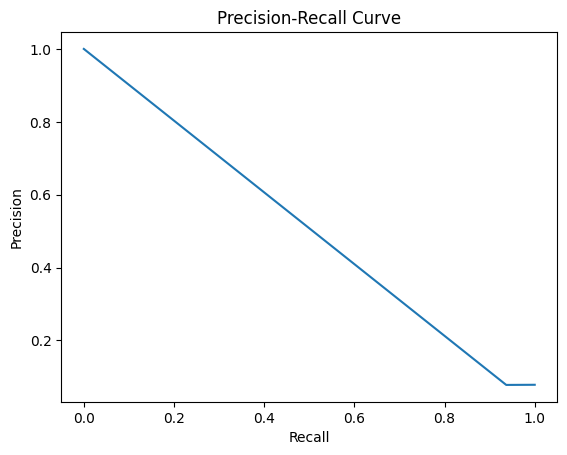

In [ ]:
show_performance(y_test, new_y_pred)